In [2]:
!pip install accelerate diffusers controlnet_aux transformers --force-reinstall

  Using cached accelerate-1.4.0-py3-none-any.whl (342 kB)
  Using cached diffusers-0.32.2-py3-none-any.whl (3.2 MB)
  Using cached controlnet_aux-0.0.9-py3-none-any.whl (282 kB)
  Using cached transformers-4.49.0-py3-none-any.whl (10.0 MB)
  Using cached psutil-7.0.0-cp36-abi3-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (277 kB)
  Using cached packaging-24.2-py3-none-any.whl (65 kB)
  Using cached torch-2.6.0-cp310-cp310-manylinux1_x86_64.whl (766.7 MB)
  Using cached huggingface_hub-0.29.2-py3-none-any.whl (468 kB)
  Using cached numpy-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Using cached PyYAML-6.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (751 kB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (471 kB)
  Using cached importlib_metadata-8.6.1-py3-none-any.whl (26 kB)
  Using cached pillow-11.1.0-cp310-cp310-manylinux_2_28_x86_64.whl (4.5 MB)


In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.6.0+cu124
True


In [2]:
import torch
from controlnet_aux import CannyDetector
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers.utils import load_image, make_image_grid

/home/fitlemon/code/kidfolio/.venv/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", 
    torch_dtype=torch.float16,
    varient="fp16")
 
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "Yntec/AbsoluteReality",
    controlnet=controlnet, 
    torch_dtype=torch.float16)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/fitlemon/code/kidfolio/.venv/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
pipe.load_ip_adapter("h94/IP-Adapter", 
                     subfolder="models", 
                     weight_name="ip-adapter_sd15.bin")
 
pipe.enable_model_cpu_offload()

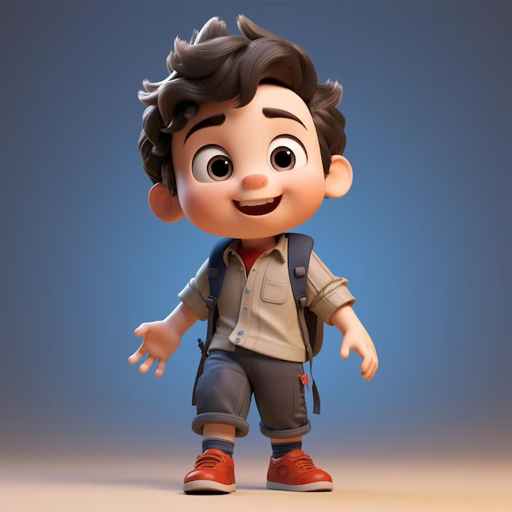

In [295]:
# load style-image
ip_adap_img = load_image("style3.png")
ip_adap_img.thumbnail((512, 512))
#display image
ip_adap_img

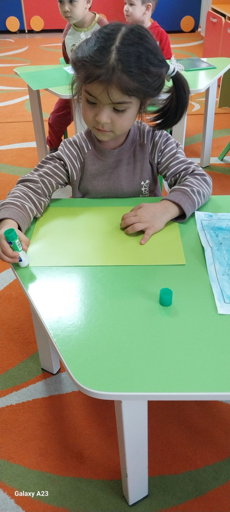

In [190]:
# load input image
img = load_image("kid2.jpg")
img.thumbnail((512, 512))
img

In [191]:
# shape of image
img.size

(230, 512)

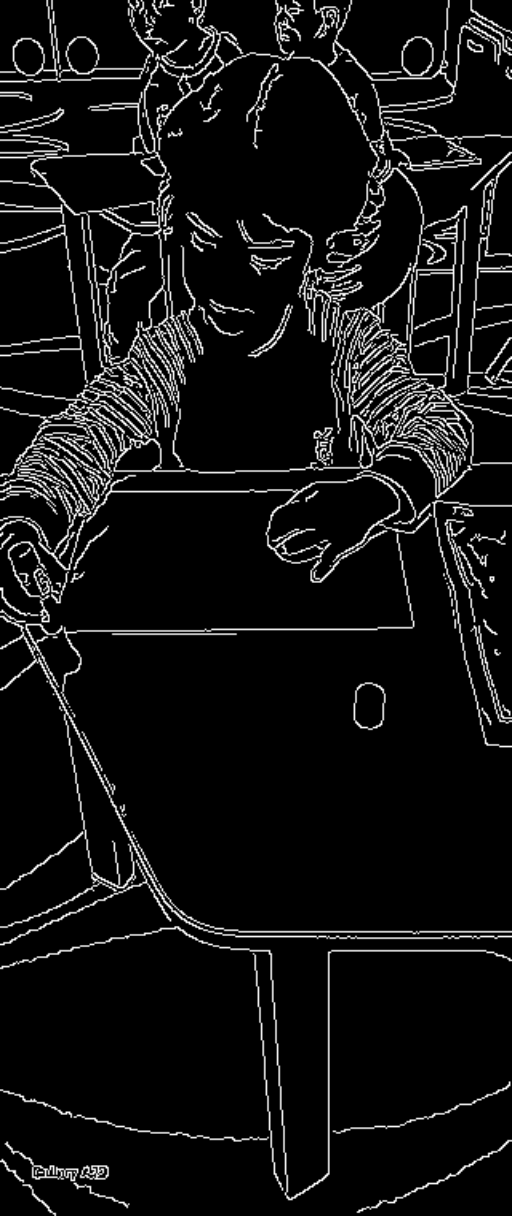

In [223]:
# detect edges
canny = CannyDetector()
canny_img = canny(img, detect_resolution=333, image_resolution=img.size[1])
 
# display image
canny_img

In [193]:
# load env with environs
from environs import Env

# env file path
path = '../.env'

# load env
env = Env()

env.read_env(path)

True

In [216]:
import base64
from PIL import Image, ImageDraw
import io
buffered = io.BytesIO()
img.save(buffered, format="JPEG")
buffered.seek(0)
img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")

In [195]:
from openai import OpenAI

client = OpenAI()

response = client.chat.completions.create(
  model="gpt-4o-mini",
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text", "text": "Describe this photograph in 2 short sentences as a prompt for generating an image in Stable Diffusion, adding vivid details (e.g. color, clothes, objects around, etc.) to help the model understand the image better. This photo is from kindergarten. Please be careful with the content. Describe only kid's activities. Add to prompt that the model should generate a happy and joyful image without NFSW."},
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{img_base64}", "detail": "low",}
        },
      ],
    }
  ],
  max_tokens=300,
)


In [196]:
prompt = response.choices[0].message.content
prompt

'A joyful kindergarten scene features a young girl with dark hair in playful pigtails, focused on drawing with a green marker on a bright green sheet of paper. In the background, colorful furniture and cheerful artwork create a lively atmosphere, while other children engage in creative activities, embodying the essence of curiosity and happiness.'

In [197]:
prompt = """(photorealistic:1.2), raw, masterpiece, high quality, 
8k, """  + prompt 

In [198]:
prompt

'(photorealistic:1.2), raw, masterpiece, high quality, \n8k, A joyful kindergarten scene features a young girl with dark hair in playful pigtails, focused on drawing with a green marker on a bright green sheet of paper. In the background, colorful furniture and cheerful artwork create a lively atmosphere, while other children engage in creative activities, embodying the essence of curiosity and happiness.'

In [ ]:
# # To use original IP-Adapter
# scale = 1.0
# pipeline.set_ip_adapter_scale(scale)

# # To use style block only
# scale = {
#     "up": {"block_0": [0.0, 1.0, 0.0]},
# }
# pipeline.set_ip_adapter_scale(scale)

# # To use style+layout blocks
# scale = {
#     "down": {"block_2": [0.0, 1.0]},
#     "up": {"block_0": [0.0, 1.0, 0.0]},
# }
# pipeline.set_ip_adapter_scale(scale)

# # To use style and layout from 2 reference images
# scales = [{"down": {"block_2": [0.0, 1.0]}}, {"up": {"block_0": [0.0, 1.0, 0.0]}}]
# pipeline.set_ip_adapter_scale(scales)

In [ ]:
pipe.

In [296]:
scale = 0.6
pipe.set_ip_adapter_scale(scale)

# generate images
images = pipe(
    prompt=prompt,
    negative_prompt="low quality",
    height=img.size[1],
    width=img.size[0],
    ip_adapter_image=ip_adap_img,
    image=canny_img,
    guidance_scale=6,
    controlnet_conditioning_scale=0.7,
    num_inference_steps=20,
    num_images_per_prompt=1,
).images

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['of curiosity and happiness.']


  0%|          | 0/20 [00:00<?, ?it/s]

In [297]:
# insert the original image in the list of generated images
images = [img] + images

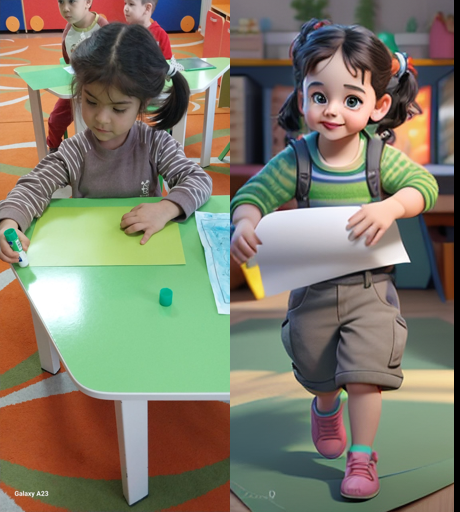

In [298]:
make_image_grid(images, cols=2, rows=1)